# darepo

This package is designed to aid in the efficient analysis of large simulations, such as cosmological (hydrodynamical) simulations of large-scale structure.

It uses the [dask](https://dask.org/) library to perform computations, which has two key advantages:
* (i) very large datasets which cannot normally fit into memory can be analyzed, and
* (ii) calculations can be automatically distributed onto parallel 'workers', across one or more (MPI) nodes, to speed them up.

In [1]:
# Notebook config
path = "../../sims.TNG/TNG50-4/output/snapdir_099/"
path = "/data/cbyrohl/TNGdata/TNG50-4/output/snapdir_099/"
path = "/home/cbyrohl/TNGdata/TNG50-4/output/snapdir_030"

# [0] Select a simulation and snapshot

The first step is to chose an existing snapshot of a simulation. To start, we will intentionally select the $z=0$ output of TNG50-4, which is the lowest resolution version of TNG50. This means that the size of data in the snapshot is small and easy to work with.

In [2]:
from darepo.interfaces.arepo import ArepoSnapshot
snap = ArepoSnapshot(path)

# [1] Get familiar with a snapshot

## Header metadata
The snapshot contains a dictionary for the AREPO simulation header, config and parameters in its namespace. We can inspect the header:

In [3]:
snap.header

{'BoxSize': 35000.0,
 'Composition_vector_length': 0,
 'Flag_Cooling': 1,
 'Flag_DoublePrecision': 0,
 'Flag_Feedback': 1,
 'Flag_Metals': 0,
 'Flag_Sfr': 1,
 'Flag_StellarAge': 0,
 'Git_commit': b'unknown',
 'Git_date': b'unknown',
 'HubbleParam': 0.6774,
 'MassTable': array([0.        , 0.01573723, 0.        , 0.00293826, 0.        ,
        0.        ]),
 'NumFilesPerSnapshot': 11,
 'NumPart_ThisFile': array([[1785559, 1834655,       0, 1967855,   17120,     266],
        [1720416, 1773023,       0, 1819404,   14310,     226],
        [1711490, 1754957,       0, 1729112,   13858,     248],
        [1804723, 1847363,       0, 1818158,   10111,     237],
        [1707943, 1755127,       0, 1727885,   15858,     235],
        [1711462, 1762328,       0, 1727154,    9216,     231],
        [1696071, 1753353,       0, 1722297,   23144,     254],
        [1800381, 1857997,       0, 1821376,   16941,     250],
        [1720397, 1784879,       0, 1744884,   18924,     235],
        [1719587

Note that only keys that are the same across all snapshot file chunks are is. 
Entries which are different for each file, such as `NumPart_ThisFile`, are stacked along the first axis, so that we also have access to this information:

In [4]:
snap.header['NumPart_ThisFile']

array([[1785559, 1834655,       0, 1967855,   17120,     266],
       [1720416, 1773023,       0, 1819404,   14310,     226],
       [1711490, 1754957,       0, 1729112,   13858,     248],
       [1804723, 1847363,       0, 1818158,   10111,     237],
       [1707943, 1755127,       0, 1727885,   15858,     235],
       [1711462, 1762328,       0, 1727154,    9216,     231],
       [1696071, 1753353,       0, 1722297,   23144,     254],
       [1800381, 1857997,       0, 1821376,   16941,     250],
       [1720397, 1784879,       0, 1744884,   18924,     235],
       [1719587, 1770867,       0, 1735776,   12323,     233],
       [1746207, 1788451,       0, 1869099,    9596,     258]],
      dtype=int32)

## Particle/cell data

Within our `snap` object, `snap.data` contains references to all the particle/cell data in this snapshot.

If the snapshot is split across multiple file chunks on disk (as is the case for most large cosmological simulations), then these are virtually "combined".

As a result, there is a single array per field in `snap.data`. Note that these are **not** normal numpy arrays, but are instead **dask arrays**, which we will return to later.

In [5]:
snap.data.keys()

dict_keys(['PartType0', 'PartType1', 'PartType3', 'PartType4', 'PartType5'])

Let's list all fields available for the respective particle species.

In [6]:
for key,val in snap.data.items():
    print("Species:", key)
    print(val.keys(), end='\n\n')

Species: PartType0
dict_keys(['Coordinates', 'Density', 'ElectronAbundance', 'GFM_Metallicity', 'InternalEnergy', 'Masses', 'ParticleIDs', 'StarFormationRate', 'Velocities', 'uid'])

Species: PartType1
dict_keys(['Coordinates', 'ParticleIDs', 'Velocities', 'uid'])

Species: PartType3
dict_keys(['ParentID', 'TracerID', 'uid'])

Species: PartType4
dict_keys(['Coordinates', 'GFM_InitialMass', 'GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses', 'ParticleIDs', 'Potential', 'Velocities', 'uid'])

Species: PartType5
dict_keys(['BH_BPressure', 'BH_CumEgyInjection_QM', 'BH_CumEgyInjection_RM', 'BH_CumMassGrowth_QM', 'BH_CumMassGrowth_RM', 'BH_Density', 'BH_HostHaloMass', 'BH_Hsml', 'BH_Mass', 'BH_Mdot', 'BH_MdotBondi', 'BH_MdotEddington', 'BH_Pressure', 'BH_Progs', 'BH_U', 'Coordinates', 'Masses', 'ParticleIDs', 'Potential', 'Velocities', 'uid'])



Note that none of these datasets have actually been loaded yet! Instead, what we have available is a convenient way to access the data via dask.

## Physical Units

When possible, we attach physical units automatically to arrays (using 'astropy.units'). This means that arrays know their units, the user can convert between different units automatically, and expressions and equations involving combinations of units can be verified for correctness.

Currently, unit support is available for AREPO/Illustris/TNG simulations in particular. Here units are available by default, based on the public documentation. You need to select a snapshot with the `ArepoSnapshotWithUnits` class.

In [7]:
from darepo.interfaces.arepo import ArepoSnapshotWithUnits
snap = ArepoSnapshotWithUnits(path)
snap.data["PartType0"]["Masses"].sum().compute()

<Quantity 8.4712995e+14 solMass>

# [2] Analyzing snapshot data

In order to perform a given analysis on some available snapshot data, we would normally first explicitly load the required data from disk, and then run some calculations on this data (in memory).

Instead, with dask, our fields are loaded automatically as well as "lazily" -- only when actually required.

## Computing a simple statistic on (all) particles

The fields in our snapshot object behave similar to actual numpy arrays. 

As a first simple example, let's calculate the total mass of gas cells in the entire simulation. Just as in numpy we can write

In [8]:
snap = ArepoSnapshot(path) # reload without units
masses = snap.data["PartType0"]["Masses"]
task = masses.sum()

Note that all objects remain 'virtual': they are not calculated or loaded from disk, but are merely the required instructions, encoded into tasks. In a notebook we can inspect these:

In [9]:
masses

dask.array<array, shape=(19124236,), dtype=float32, chunksize=(19124236,), chunktype=numpy.ndarray>

In [10]:
task

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

We can request a calculation of the actual operation(s) by applying the `.compute()` method to the task.

In [11]:
task.compute()

57384.594

## Creating a visualization: projecting onto a 2D image

As an example of calculating something more complicated than just `sum()`, let's do the usual "poor man's projection" via a 2D histogram.

To do so, we use [da.histogram2d()](https://docs.dask.org/en/latest/array.html) of dask, which is analogous to [numpy.histogram2d()](https://numpy.org/doc/stable/reference/generated/numpy.histogram2d.html), except that it operates on a dask array.

In [12]:
import dask.array as da
import numpy as np

coords = snap.data["PartType0"]["Coordinates"]
x = coords[:,0]
y = coords[:,1]

nbins = 128
bins1d = np.linspace(0,snap.header["BoxSize"],nbins+1)

result = da.histogram2d(x,y,bins=[bins1d,bins1d])
im2d = result[0].compute()

The resulting `im2d` is just a two-dimensional array which we can display.

In [13]:
im2d.shape

(128, 128)

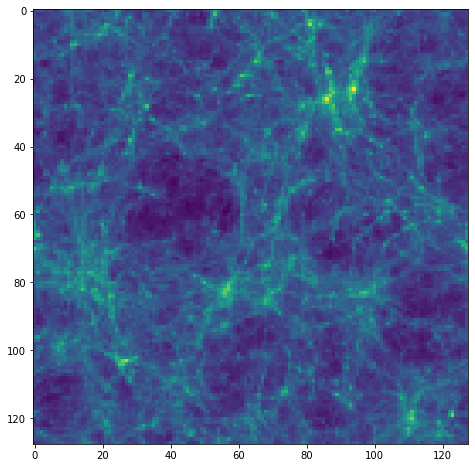

In [14]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(8,8))
plt.imshow(im2d,norm=LogNorm())
plt.show()

# [3] Scaling up: handling a large simulation

Until now, we have applied our framework to a very small simulation. 

However, what if we are working with a very large simulation (like TNG50-1, with $8^3 = 512$ times more particles/cells)?

## Starting simple: computing in chunks

First, we can still run the same calculation as above, and it will "just work" (hopefully).

This is because Dask has many versions of common algorithms and functions which work on "blocks" or "chunks" of the data, which split up the large array into smaller arrays. Work is needed on each chunk, after which the final answer is assembled.

Importantly, in our case above, even if the `mass` array above does not fit into memory, the `mass.sum().compute()` will chunk the operation up in a way that the task can be calculated.

In [15]:
#snap_large = ArepoSnapshot(path.replace('TNG50-4','TNG50-2'))

In [16]:
#snap_large.header["NumPart_Total"]

Before we start, let's enable a progress indicator from dask:

In [17]:
#from dask.diagnostics import ProgressBar
#ProgressBar().register()

And then we can request the actual computation:

In [18]:
#snap_large.data["PartType0"]["Masses"].sum().compute()

While the result is eventually computed, it is a bit slow, primarily because the actual reading of the data off disk is the limiting factor, and this is happening in serial.

## More advanced: computing in parallel

Rather than sequentially calculating large tasks, we can also run the computation in parallel. 

To do so different advanced dask schedulers are available. Here, we use the most straight forward [distributed scheduler](https://docs.dask.org/en/latest/how-to/deploy-dask/single-distributed.html).

Usually, we would start a scheduler and then connect new workers (e.g. running on multiple compute/backend nodes of a HPC cluster). After, tasks (either interactively or scripted) can leverage the power of these connected resources.

For this example, we will use the same "distributed" scheduler/API, but keep things simple by using just the one (local) node we are currently running on.

In [19]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4,threads_per_worker=1)
client = Client(cluster)

In [20]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.26 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41607,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 15.26 GiB
Comm: tcp://127.0.0.1:33495,Total threads: 1
Dashboard: http://127.0.0.1:39425/status,Memory: 3.81 GiB
Nanny: tcp://127.0.0.1:45541,


We can now perform the same operations, but it is performed in a distributed manner, in parallel.

One significant advantage is that (even when using only a single node) individual workers will load just the subsets of data they need to work on, meaing that I/O operations become parallel.

Note: after creating a `Client()`, all calls to `.compute()` will automatically use this new set of workers.

In [21]:
#task = snap_large.data["PartType0"]["Masses"].sum()
#task.compute()

We can also view the progress of this task as it executes. For the distributed scheduler, a status dashboard exists (as a webpage).

You can find it by clicking on the "Dashboard" link above. If running this notebook server remotely, e.g. on a login node of a HPC cluster, you may have to change the '127.0.0.1' part of the address to be the same machine name/IP.

# [4] Custom analysis functions

TODO
(beyond simple statistics/build-in numpy methods)

# [5] Halo and Galaxy Catalogs

Cosmological simulations are often post-processed with a substructure identification algorithm in order to identify halos and galaxies. The resulting catalogs can be loaded and connect with the particle-level snapshot data.

Currently, we support the usual FOF/Subfind combination and format. Their presence will be automatically detected and the catalogs will be loaded into `snap.data` as shown below.

In [30]:
from darepo.interfaces.arepo import ArepoSnapshot
snap = ArepoSnapshot(path,catalog=path.replace("snapdir","groups"))
snap.data["Group"]["GroupMass"]

dask.array<array, shape=(30975,), dtype=float32, chunksize=(30975,), chunktype=numpy.ndarray>

Normal halo and subhalo catalog properties can then be accessed. Note that it is rarely required to use dask functionality to analyze or plot catalog values, since these arrays are not too large.

## Which [sub]halos do particles belong to?

As a convenience method, we tag every particle/cell with two additional fields: `GroupID` and `SubhaloID` which give the IDs of the parent \[sub\]halos. A value of `-1` indicates the lack of an associated group/subhalo. This allows you to easily select all the members of a \[sub\]halo.

For example, let's get all group and subhalo IDs for all black holes:

In [31]:
print("Group IDs for chosen particles:", snap.data["PartType5"]["GroupID"].compute())
print("Subhalo IDs for chosen particles:", snap.data["PartType5"]["SubhaloID"].compute())

Group IDs for chosen particles: [    0     0     0 ...  6873  7510 10492]
Subhalo IDs for chosen particles: [ 0  0  0 ... -1  0 -1]


## Selecting particles/cells which belong to a particular [sub]halo?
We can select all particle data for a given halo ID.

In [32]:
data = snap.return_data(haloID=42) # the result contains all fields for all particle types for a given halo
data["PartType0"]["Density"] # density for all gas particles in halo

dask.array<getitem, shape=(4435,), dtype=float32, chunksize=(4435,), chunktype=numpy.ndarray>

# Operations on particle data for all halos
Often we want to perform a data reduction for all data of a given halo. Naively, one would loop over each halo applying the operation needed. This can be both tedious to write and slow. Instead, we can do this kind of operation with the snapshot easily. The operations are put into dask tasks, but also with multiple operations per dask task to reduce overhead. **Until now only scalar operation, i.e. those that output a scalar for each halo, are supported.**

In [37]:
from darepo.interfaces.arepo import ArepoSnapshot
snap = ArepoSnapshot(path,catalog=path.replace("snapdir","groups"))

In [38]:
def calculate_mass(mass, sfrs, fieldnames=["Masses","StarFormationRate"], parttype="PartType0"):
    """Return all gas mass that is star-forming."""
    return mass[sfrs>0].sum()

totgasmasses_sf = snap.map_halo_operation(calculate_mass).compute()
totgasmasses_sf

array([14.372824 ,  4.7390265,  7.1822767, ...,  0.       ,  0.       ,
        0.       ], dtype=float32)

# [6] Derived snapshot fields

A common analysis task is to convert one or more snapshot fields into a new field. For example, while the temperature, pressure, or entropy of gas is not stored directly in the snapshots, they can be computed from fields which are. 

We can define such "derived fields" by writing their generating function and giving them a name. They can then be "loaded" from snapshots as if they were actual datasets -- for analysis, there is no difference between derived and on-disk fields.


## An example: velocity magnitude

As a simplest first example, note that the 3-vector of "Velocities" is stored in the snapshot for all particle types, but the magnitude is not. We can define a derived field for the stars as:

In [33]:
import numpy as np

@snap.register_field("stars")
def VelMag(arrs, **kwargs):
    vel = arrs['Velocities']
    return np.sqrt( vel[:,0]**2 + vel[:,1]**2 + vel[:,2]**2 )

In [34]:
vmag = snap.data["PartType4"]["VelMag"]
vmag.max().compute()

5291.891

## A second example: gas temperature

For example, to compute the gas temperature we need the mean molecular weight,

$\mu = \frac{4}{ 1 + 3 X_H + 4 X_H x_e } * m_p$

Then, the temperature in Kelvin is given by

$T = (\gamma - 1) * u / k_B * \frac{\rm{UnitEnergy}}{\rm{UnitMass}} * \mu$

We can create this derived field (for the standard unit system) as:

In [35]:
@snap.register_field("gas")
def Temperature(arrs, **kwargs):
    """ Compute gas temperature given (ElectronAbundance,InternalEnergy) in [K]. """
    xh = 0.76
    gamma = 5.0 / 3.0
    
    m_p = 1.672622e-24 # proton mass [g]
    k_B = 1.380650e-16 # boltzmann constant [erg/K]
    
    UnitEnergy_over_UnitMass = 1e10 # standard unit system (TODO: can obtain from snapshot)
    
    xe = arrs['ElectronAbundance']
    u_internal = arrs['InternalEnergy']
    
    mu = 4 / (1 + 3*xh + 4*xh*xe) * m_p
    temp = (gamma - 1.0) * u_internal / k_B * UnitEnergy_over_UnitMass * mu
    
    return temp

## Derived fields: reference

To create a new derived field we need to define a new function `fieldname(arrs, **kwargs)` whose first argument `arrs` is a dictionary holding the keys available for the given data type (e.g. gas) and can be used to deduce new fields. The new function should structured and decorated as:

```python
@snap.register_field(parttype, name="fieldname")
def fieldname(arrs, **kwargs):
    new_field = do_stuff(arrs['key1'], arrs['key2'])
    return new_field
```

if no `name` is given to the decorator, the function name can be used to refer to it.

# [7] Next Steps

(what the caching warning means, how to use some caching)

(some links to docs of relevance etc)